In [136]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as pa

In [219]:
working_dir = '/Users/user/Documents/'

In [15]:
from enum import Enum
class Split(Enum):
    HORIZONTAL = 1
    VERTICAL = 2

In [76]:
def inverse_split(split):
    if split == Split.HORIZONTAL:
        return Split.VERTICAL
    elif split == Split.VERTICAL:
        return Split.HORIZONTAL
    else:
        assert(False)

In [220]:
# rect = (x_left, y_down, x_right, y_upper)
#
#             x_left             x_right 
#
# y_down      |------------------|
#             |                  |
#             |                  |
#             |                  |
# y_upper     |------------------|

import copy

class TreeRectangle:
    def __init__(self, rect=(0.0, 0.0, 1.0, 1.0)):
        assert(len(rect) == 4)
        self.x_left = rect[0]
        self.y_down = rect[1]
        self.x_right = rect[2]
        self.y_upper = rect[3]
        assert(self.x_size() > 0 and self.y_size() > 0)
        for coord in rect:
            assert(self.check_component(coord))
            
    def get_start_point(self):
        return (self.x_left, self.y_down)
            
    def x_size(self):
        return self.x_right - self.x_left
    
    def y_size(self):
        return self.y_upper - self.y_down
 
    def __repr__(self):
         return '({}, {}, {}, {})'.format(self.x_left, self.y_down, self.x_right, self.y_upper)

    def __str__(self):
         return '({}, {}, {}, {})'.format(self.x_left, self.y_down, self.x_right, self.y_upper)
        
    def create_sub_rectangle(self, ratio, shift, split_type):
        sub_rectangle = copy.copy(self)
        if split_type == Split.HORIZONTAL:
            sub_size = ratio * (self.y_upper - self.y_down)
            sub_rectangle.y_down += shift
            sub_rectangle.y_upper = sub_rectangle.y_down + sub_size
        elif split_type == Split.VERTICAL:
            sub_size = ratio * (self.x_right - self.x_left)
            sub_rectangle.x_left += shift
            sub_rectangle.x_right = sub_rectangle.x_left + sub_size
        else:    
            assert(False)
        return sub_rectangle
        
    def check_component(self, coord):
        return 0.0 <= coord <= 1.0
    
    def check_ratios(self, ratios):
        sum_ratios = sum(ratios)
        if not (abs(sum_ratios - 1.0) < 1e-10):
            print(sum_ratios)
            assert(False)
    
    def split(self, ratios, split_type):
        self.check_ratios(ratios)
        
        splitted_rectangles = []
        cummulative_shift = 0.0
        for ratio in ratios:
            sub_rect = self.create_sub_rectangle(ratio, cummulative_shift, split_type)
            splitted_rectangles.append(sub_rect)
            if split_type == Split.HORIZONTAL:
                cummulative_shift += splitted_rectangles[-1].y_size() 
            elif split_type == Split.VERTICAL:
                cummulative_shift += splitted_rectangles[-1].x_size()
        return splitted_rectangles

In [221]:
base_rectangle = TreeRectangle()

In [222]:
spliited_rects = base_rectangle.split([0.1, 0.4, 0.5], Split.HORIZONTAL)

In [223]:
for rect in spliited_rects:
    print(rect)

(0.0, 0.0, 1.0, 0.1)
(0.0, 0.1, 1.0, 0.5)
(0.0, 0.5, 1.0, 1.0)


In [224]:
spliited_rects_2

[(0.0, 0.0, 0.1, 0.1), (0.1, 0.0, 1.0, 0.1)]

In [225]:
import os

class TreeMap:
    def __init__(self, directory):
        self.rects = {}
        self.size_map = {}
        self.calc_size_map(directory)
        self.process_dir(directory, TreeRectangle(), Split.HORIZONTAL)
        
    def calc_size_map(self, directory):
        total_size = 0
        for filename in os.listdir(directory):
            full_path = os.path.join(directory, filename)
            if os.path.isdir(full_path):
                self.calc_size_map(full_path)
            else:
                self.size_map[full_path] = os.path.getsize(full_path)
            total_size += self.size_map[full_path]
        self.size_map[directory] = total_size
    
    def process_dir(self, directory, parent_rect, split_type):
        files_paths = [os.path.join(directory, filename) for filename in os.listdir(directory)]
        
        ratios = []
        for file_path in files_paths:
            ratios.append(self.size_map[file_path] / self.size_map[directory])
        
        new_rects = parent_rect.split(ratios, split_type)
        for i in range(len(files_paths)):
            file_path = files_paths[i]
            cur_rect = new_rects[i]
            if os.path.isdir(file_path):
                self.process_dir(file_path, cur_rect, inverse_split(split_type))
            elif os.path.isfile(file_path):
                self.rects[file_path] = cur_rect
            else:
                assert(False)  

In [226]:
import random

class TreeMapVisualizer:
    def __init__(self, tree_map):
        self.tree_map = tree_map
        self.extension_color_map = {}
        
    def create_plt_rectangle(self, rect, color):
        return pa.Rectangle(rect.get_start_point(), rect.x_size(), rect.y_size(), color=color)
        
    def generate_new_color(self, ext):
        self.extension_color_map[ext] = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        
        #self.extension_color_map[ext] = (random.uniform(0,1), random.uniform(0,1), random.uniform(0,1))
        
    def visualize(self, figure):
        #figure_size = figure.get_size_inches()*figure.dpi
        for file_path, rect in self.tree_map.rects.items(): 
            extension = os.path.splitext(file_path)[1]
            if extension not in self.extension_color_map:
                self.generate_new_color(extension)
            figure.gca().add_patch(self.create_plt_rectangle(rect, self.extension_color_map[extension]))

In [227]:
tree_map = TreeMap(working_dir)

0


AssertionError: 

In [ ]:
visualizer = TreeMapVisualizer(tree_map)

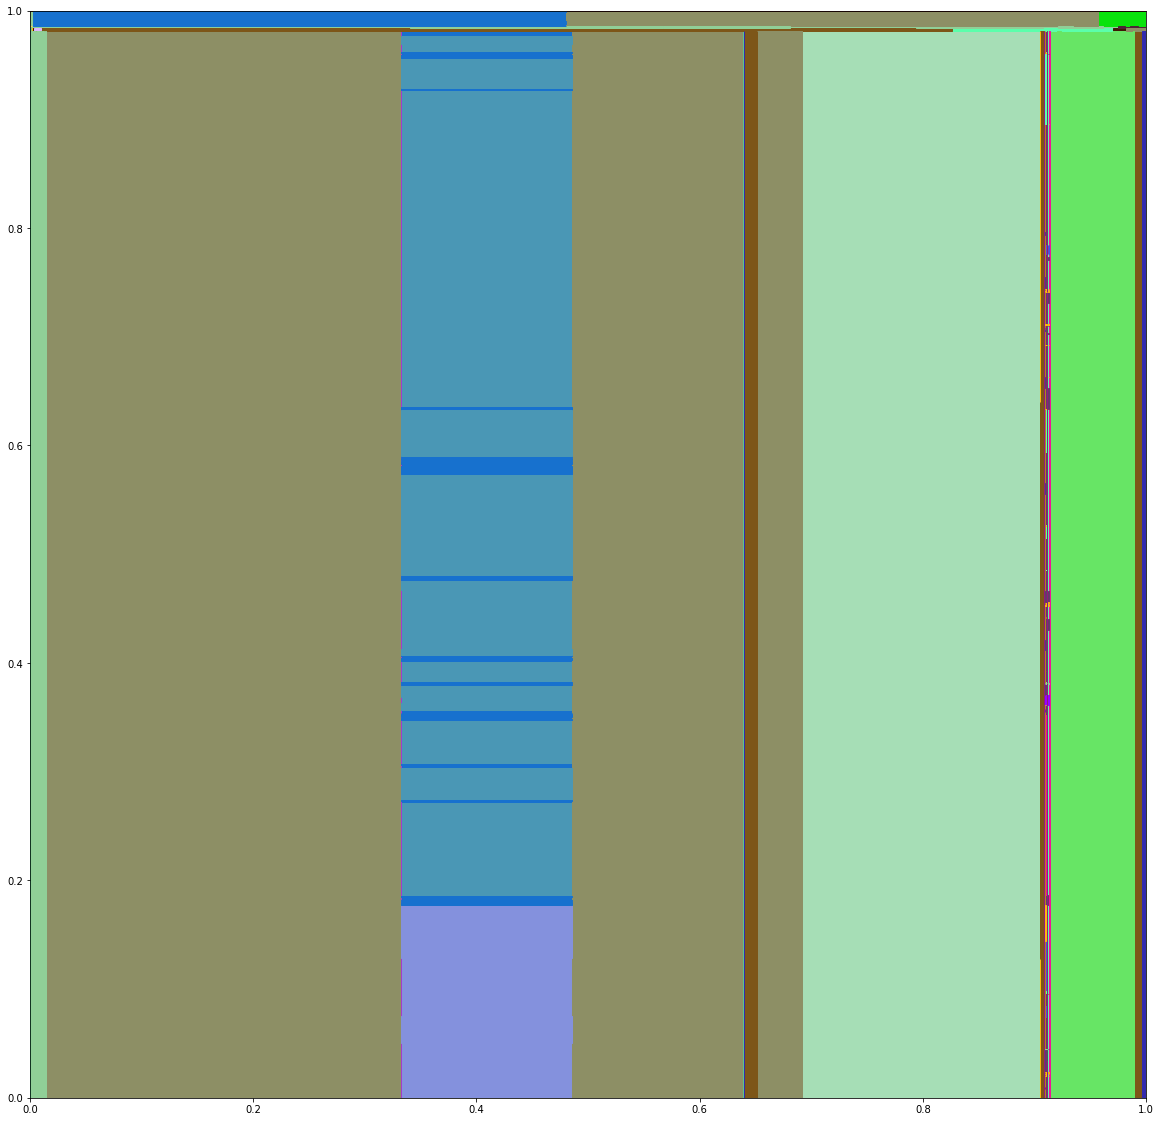

In [210]:
%matplotlib inline

visualizer.visualize(plt.figure(figsize=(20, 20)))